## Visualize the marine heatwaves tracked

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FFMpegWriter
from matplotlib import animation, rc
from IPython.display import HTML


### Import preprocessed data 

In [2]:
blobs = xr.open_dataset('02_tracked.nc', engine='netcdf4')
blobs

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 720, time: 478)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
Data variables:
    labels   (time, lat, lon) float64 ...

In [3]:
ds = xr.open_dataset('01_preprocessed.nc', engine='netcdf4')
ds

<xarray.Dataset>
Dimensions:           (time: 478, lat: 720, lon: 1440, month: 12)
Coordinates:
  * lon               (lon) float32 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * time              (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    features_notrend  (time, lat, lon) float64 ...
    ssta_notrend      (time, lat, lon) float64 ...
    stdev             (month, lat, lon) float64 ...
    mask              (lat, lon) bool ...
Attributes:
    description:  OISST v2.1 preprocessed for Ocetrac
    threshold:    90th percentile
    climatology:  entire period

In [4]:
blobs.labels.attrs

{'inital objects identified': 13161,
 'final objects tracked': 832,
 'radius': 8,
 'size quantile threshold': 0.75,
 'min area': 2505.0,
 'percent area reject': 0.2017659936328879,
 'percent area accept': 0.7982340063671121}

In [ ]:
from matplotlib.colors import ListedColormap
maxl = int(np.nanmax(blobs.labels.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())


In [ ]:
blobs.labels.sel(time=slice('12-01-2013', '04-01-2014')).plot(col='time', col_wrap=4)

In [5]:
i = 696
event = blobs.labels.where(blobs.labels==i, drop=True)
event.shape

(60, 540, 1440)

In [ ]:
# plt.pcolormesh(blobs.lon, blobs.lat, event[0,:,:], vmin=0, vmax=2, cmap='gist_heat_r',transform=ccrs.PlateCarree())
# event.sel(time='12-01-2013').plot.contourf()

/burg/home/hs3277/.conda/envs/ocetrac/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


RuntimeError: Requested MovieWriter (ffmpeg) not available

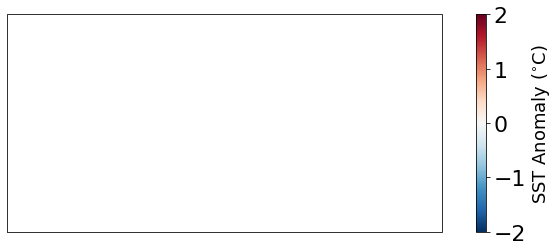

In [6]:
# Create intensity image for the Indian Ocean marine heatwave
event_intensity = ds.ssta_notrend.where((ds.time==event.time) & 
                                             (ds.lat==event.lat) & 
                                             (ds.lon==event.lon), 
                                             drop=True).load();
event_intensity = event_intensity.expand_dims(dim='intensity', axis=3)
events_contour = event.fillna(0)


# Make animation
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
fig = plt.figure(figsize=(12,4)) 
plt.rcParams['animation.ffmpeg_path'] = '/glade/u/apps/dav/opt/ffmpeg/4.1.3/gnu/8.3.0/bin/ffmpeg'
plt.rcParams['animation.embed_limit'] = 2**128


ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=180, globe=None))
ax.coastlines(resolution='110m', color='black', linewidth=1); ax.add_feature(cfeature.LAND, facecolor='w')
plt.title(event.isel(time=0).time.values.astype('datetime64[D]'))
im = event_intensity.isel(time=0, intensity=0).plot(transform=ccrs.PlateCarree(), vmin=-2, vmax=2, 
                                                  cmap='RdBu_r', extend='both', add_colorbar=False, 
                                                  add_labels=False)
cb = plt.colorbar(im); cb.set_label(label=r'SST Anomaly ($\rm^{\circ}$C)', size=18)
events_contour.isel(time=0).plot.contour(levels=[i,i+1], transform=ccrs.PlateCarree(), colors='m', linewidths=3, add_colorbar=False, add_labels=False)
ax.set_global(); ax.clear()

def animate(c):
        ax = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=180, globe=None)); ax.clear()
        ax.coastlines(resolution='110m', color='black', linewidth=1); ax.add_feature(cfeature.LAND, facecolor='w')
        plt.title(event.isel(time=c).time.values.astype('datetime64[D]'))
        im = event_intensity.isel(time=c, intensity=0).plot(transform=ccrs.PlateCarree(), vmin=-2, vmax=2, 
                                                  cmap='RdBu_r', extend='both', add_colorbar=False, 
                                                  add_labels=False)
        
        events_contour.isel(time=c).plot.contour(levels=[i,i+1], transform=ccrs.PlateCarree(), colors='m', linewidths=3, add_colorbar=False, add_labels=False)
        ax.set_global()

anim = animation.FuncAnimation(fig, animate, frames=event.shape[0])

# # Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, bitrate=1800)
outpath = '/burg/home/hs3277/ocetrac/notebooks/Pacific_Event.mp4'
anim.save(outpath, writer=writer, dpi=300)

HTML(anim.to_jshtml())

# plt.rc('font', size=12); plt.figure(figsize=(15,6));
# for c in enumerate(range(1,6)):#len(event.time))):
#     ax = plt.subplot(2,3,c[1],projection=ccrs.PlateCarree(central_longitude=180, globe=None))
#     event_intensity.isel(time=c[0], intensity=0).plot(transform=ccrs.PlateCarree(), vmin=-2, vmax=2,  
#                                                       cmap='RdBu_r', extend='both', add_colorbar=True, add_labels=False)
#     plt.title(event.isel(time=c[0]).time.values.astype('datetime64[D]'))
#     ax.coastlines(resolution='110m', color='black', linewidth=1) 
#     ax.add_feature(cfeature.LAND, facecolor='w');
#     events_contour.isel(time=c[0]).plot.contour(levels=[i,i+1], transform=ccrs.PlateCarree(), colors='b', linewidths=4, add_colorbar=False, add_labels=False)
    
    

In [ ]:
# Make animation
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
fig = plt.figure(figsize=(12,10)) 
plt.rcParams['animation.ffmpeg_path'] = '/glade/u/apps/dav/opt/ffmpeg/4.1.3/gnu/8.3.0/bin/ffmpeg'
plt.rcParams['animation.embed_limit'] = 2**128

ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=180, globe=None))
plt.gca().patch.set_color('.35')
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=1) 
im = event.sel(time='12-01-2013').plot()
plt.pcolormesh(blobs.lon, blobs.lat, event[0,:,:], vmin=0, vmax=2, cmap='gist_heat_r',transform=ccrs.PlateCarree())
# cb = plt.colorbar(im); cb.set_label(label=r'Marine Heatwave Anomalies ($\rm^{\circ}$C)', size=24)
ax.set_global();ax.clear()

# def animate(i):
#         ax = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=245, central_latitude=20.0, globe=None)); ax.clear()
#         plt.gca().patch.set_color('.35')
#         ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=1) 
#         im = plt.pcolormesh(mhw_ssta_maps.lon, mhw_ssta_maps.lat, mhw_ssta_maps[i,:,:], vmin=0, vmax=2, cmap='gist_heat_r',transform=ccrs.PlateCarree())
#         plt.plot(mhw_ssta_maps.lon.sel(lon=220.125), mhw_ssta_maps.lat.sel(lat=45.125), 'x', color='lime', ms=20, markeredgewidth=3, transform=ccrs.PlateCarree())
#         plt.title(str(mhw_ssta_maps.time[i].dt.strftime('%Y-%m').values), fontsize=36)
#         ax.set_global()

# anim = animation.FuncAnimation(fig, animate, frames=mhw_ssta_maps.shape[0])

# # # Set up formatting for the movie files
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=2, bitrate=1800)
# outpath = '/glade/u/home/scanh/NCAR-CGD-seminar/movies/NorthPacific_MHWs.mp4'
# anim.save(outpath, writer=writer, dpi=300)

# HTML(anim.to_jshtml())


In [ ]:
from matplotlib.colors import ListedColormap
maxl = int(np.nanmax(blobs.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())

plt.figure(figsize=(16,3))
ax1 = plt.subplot(121);blobs.isel(time=0).plot(cmap= cm)
mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax1.set_aspect('equal')
ax2 = plt.subplot(122); features_ssta.isel(time=0).plot(cmap='Reds', vmin=0, vmax=3);
mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax2.set_aspect('equal');

In [ ]:
id = 35
event = blobs.where(blobs==id, drop=True)
event.shape

In [ ]:
# Create intensity image for the Indian Ocean marine heatwave
event_intensity = ds.anom.isel(zlev=0).where((ds.time==event.time) & 
                                             (ds.lat==event.lat) & 
                                             (ds.lon==event.lon), 
                                             drop=True).load();
event_intensity = event_intensity.expand_dims(dim='intensity', axis=3)
events_contour = event.fillna(0)

plt.rc('font', size=12); plt.figure(figsize=(15,6));
for i in enumerate(range(1,len(event.time))):
    ax = plt.subplot(2,3,i[1],projection=ccrs.PlateCarree())
    event_intensity.isel(time=i[0], intensity=0).plot(transform=ccrs.PlateCarree(), vmin=-2, vmax=2,  
                                                      cmap='RdBu_r', extend='both', add_colorbar=True, add_labels=False)
    plt.title(event.isel(time=i[0]).time.values.astype('datetime64[D]'))
    ax.coastlines(resolution='110m', color='black', linewidth=1) 
    ax.add_feature(cfeature.LAND, facecolor='w');
    events_contour.isel(time=i[0]).plot.contour(levels=[34,35], transform=ccrs.PlateCarree(), colors='b', linewidths=4, add_colorbar=False, add_labels=False)

In [ ]:
mo = Tracker._morphological_operations()

In [ ]:
mo.isel(time=0).plot()